In [ ]:
from src.utils.models import MODEL
from src.utils.helpers import get_today_str, get_prompt_template
from src.deep_research_agent.state import AgentState,AgentInputState
from pydantic import BaseModel, Field
from src.config import ROOT_DIR
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
import os
from typing import Literal
from langgraph.checkpoint.memory import InMemorySaver

from IPython.display import Image, display
from src.utils.notebook_utils import format_messages


# Scoping Agent

In [ ]:
class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions."""
    
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )


class ResearchQuestion(BaseModel):
    """Schema for structured research brief generation."""
    
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

In [ ]:
# Set up structured output model
CLARIFY_WITH_USER_PROMPT_TEMPLATE = get_prompt_template(os.path.join(ROOT_DIR, "src/deep_research_agent/prompts/clarify_with_user_instruction.jinja"))
WRITE_RESEARCH_BRIEF_PROMPT_TEMPLATE = get_prompt_template(os.path.join(ROOT_DIR, "src/deep_research_agent/prompts/write_research_brief_from_messages.jinja"))

def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", END]]:
    """
    Determine if the user's request contains sufficient information to proceed with research.
    
    Uses structured output to make deterministic decisions and avoid hallucination.
    Routes to either research brief generation or ends with a clarification question.
    """
    structured_output_model = MODEL.with_structured_output(ClarifyWithUser)
    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=CLARIFY_WITH_USER_PROMPT_TEMPLATE.render(
            messages=get_buffer_string(messages=state["messages"]), 
            date=get_today_str()
        ))
    ])
    
    # Alternately can also go to a dedicated node to ask human for clarification question
    # Route based on clarification need
    if response.need_clarification:
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_research_brief", 
            update={"messages": [AIMessage(content=response.verification)]}
        )


def write_research_brief(state: AgentState):
    """
    Transform the conversation history into a comprehensive research brief.
    
    Uses structured output to ensure the brief follows the required format
    and contains all necessary details for effective research.
    """
    # Set up structured output model
    structured_output_model = MODEL.with_structured_output(ResearchQuestion)
    
    # Generate research brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=WRITE_RESEARCH_BRIEF_PROMPT_TEMPLATE.render(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])
    
    # Update state with generated research brief and pass it to the supervisor
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }

In [ ]:
builder = StateGraph(AgentState,input_schema=AgentInputState)
builder.add_node( "clarify_with_user",clarify_with_user)
builder.add_node("write_research_brief",write_research_brief)
builder.add_edge(START, "clarify_with_user")
builder.add_edge("write_research_brief", END)


In [ ]:
checkpointer = InMemorySaver()
scope_graph = builder.compile(checkpointer=checkpointer)
display(Image(scope_graph.get_graph(xray=True).draw_mermaid_png()))

# Testing

In [ ]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = scope_graph.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

In [ ]:
result = scope_graph.invoke({"messages": [HumanMessage(content="I don't have any details please proceed")]}, config=thread)
format_messages(result['messages'])

In [ ]:
from src.deep_research_agent.agents.final_deep_research_agent import DeepResearchAgent

In [6]:
agent = DeepResearchAgent().build_agent_graph()

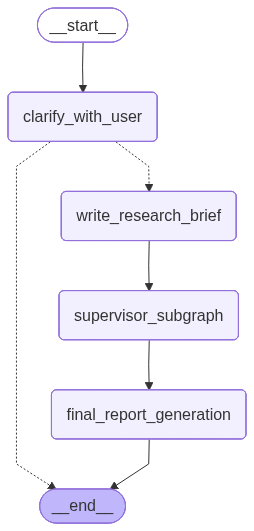

In [7]:
agent

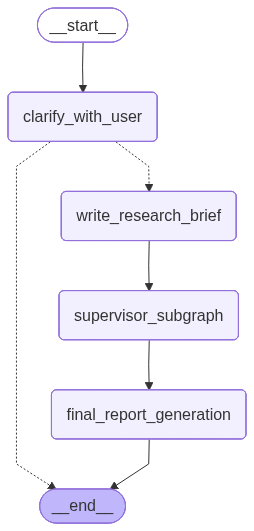

In [8]:

from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))